In [1]:
# Version 1.4 of tutorial: V.A. Moss, based on tutorial from M.A. Brentjens 08/08/2017
# This imports necessarily pylab functions from numpy and matplotlib
%pylab notebook
import os
import sys
import time
import datetime
rc('font',**{'size':12})

# Nice fonts (but do not play nice with Windows)
#rc('text', usetex=True) 
#rc('font',**{'family':'serif','serif':['serif'],'size':12})

start1 = time.time()
import datetime
from scipy import ndimage

# Import Michiel's LOFAR antenna database
from lofarantpos.db import LofarAntennaDatabase

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Convert subband number to central frequency
def sb_from_freq(freq,clock=200e6):
    chan = 0.5*clock/512.
    sb = round(freq/chan)
    return int(sb)

# Convert central frequency to subband number
def freq_from_sb(sb,clock=200e6):
    chan = 0.5*clock/512.
    freq = (sb*chan)
    return freq

# Get the rotation
rotdict = {}
rots = open('stationrotations.txt','rU')
for line in rots:
    if line.startswith('station'):
        continue
    col = line.split()
    rotdict[col[0]] = float(col[1])

/Users/moss/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 'U' mode is deprecated
  from ipykernel import kernelapp as app


In [3]:
# Initialisation parameters
# Modified to match output from M. Mancini script
cubename = '20170720_095816_mode_3_xst_sb297.dat'
station = 'DE603LBA'
stype = 'intl'

# Needed for NL stations: inner (mode 3/4), outer (mode 1/2), (sparse tbd)
# Should be set to 'inner' if stype = 'intl'
if cubename.split('_')[3] == '1' or cubename.split('_')[3] == '2':
    atype == 'outer'
elif cubename.split('_')[3] == '3' or cubename.split('_')[3] == '4':    
    atype = 'inner'
    
# Get subband from filename
subband = int(cubename.split('_')[5][2:].split('.')[0])

# Get the data
fname = '_'.join(cubename.split('_')[0:2])+'_'+station+'_SB'+str(subband)
im_x,im_y = 101,101
freq = freq_from_sb(subband)

# Which slice in time to visualise
timestep = 0

# Calculate start time
starttime = datetime.datetime.strptime(cubename.split('_')[1],'%H%M%S')

# For ground imaging
dims = np.array([-250,250,-250,250]) # metres
height = 1.5 # metres

# Confirm the data has been read correctly
print("""Filename: %s
Station: %s
Station type: %s
Array type: %s
Subband: %s
Timestep: %s
Save title: %s
Sky image size: %s x %s
Ground image size: %s x %s m 
Ground height: %s m
""" % (cubename,station,stype,atype,subband,fname,im_x,im_y,timestep,dims[1]-dims[0],dims[3]-dims[2],height))


Filename: 20170720_095816_mode_3_xst_sb297.dat
Station: DE603LBA
Station type: intl
Array type: inner
Subband: 297
Timestep: 20170720_095816_DE603LBA_SB297
Save title: 101
Sky image size: 101 x 0
Ground image size: 500 x 500 m 
Ground height: 1.5 m



In [4]:
# Read in calibration tables, by M. Brentjens (integrated 09/10/2017)
def read_caltable(field_name, rcu_mode, config_dir = '/Users/moss/Documents/LOFAR/imaging/rfisearch/caltables', num_subbands = 512):
   r'''
   Reads a station's calibration table.

   **Parameters**

   field_name : string
       The name of the antenna field, for example 'DE602LBA'

   rcu_mode : integer
       The receiver mode for which the calibration table is
       requested. An integer from 1 to 7 inclusive.

   config_dir : string
       Root directory under which station information is stored in
       subdirectories DE602C/etc/, RS106/etc/,...

   num_subbands : integer
       Number of subbands in the station polyphase filter. Use 512
       for LOFAR.

   **Returns**

   A tuple containing a list of strings representing the header
   lines, and a 2D numpy.array of complex numbers representing the
   station gain coefficients.

   **Examples**

   >>> header_lines, cal_data = read_caltable('DE602LBA', rcu_mode=3)
   >>> print(''.join(header_lines))
   HeaderStart
   CalTableHeader.Observation.Station = DE602
   CalTableHeader.Observation.Mode = 3
   CalTableHeader.Observation.Source = all
   CalTableHeader.Observation.Date = 06-10-2012
   CalTableHeader.Calibration.Version = 5120
   CalTableHeader.Calibration.Name = eikelboom
   CalTableHeader.Calibration.Date = 16-10-2012
   CalTableHeader.Calibration.PPSDelay = [56 61 2 3 58 62 0 8 57 61 0 6 57 61 0 6 63 2 9 12 63 2 9 11 63 3 11 14 63 63 8 12 0 3 10 13 63 3 11 15 1 2 10 16 3 10 14 19 60 63 4 6 63 3 9 16 63 2 10 15 61 63 4 9 27 27 37 42 26 27 38 43 24 28 36 42 19 24 29 35 9 13 21 24 9 11 19 24 8 13 18 20 9 11 18 24 ]
   CalTableHeader.Comment = Antennas 52, 54 and 71 flagged for both polarizations
   HeaderStop
   <BLANKLINE>
   >>> cal_data.shape
   (512, 192)
   >>> cal_data[0:5, 10]
   array([ 1.03373240-0.09869793j,  1.03365487-0.0995066j ,
           1.03357671-0.10031521j,  1.03349791-0.10112376j,
           1.03341849-0.10193224j])
   >>> read_caltable('DE602LBA', rcu_mode=18)
   Traceback (most recent call last):
   ...
   IOError: [Errno 2] No such file or directory: 'test/DE602C/etc/CalTable_mode18.dat'

   '''
   station, field = field_name[0:5].upper(), field_name[5:].upper()
   station_number = station[2:5]

   # Map to the correct file depending on the RCU mode
   try:
       if rcu_mode == 'outer' and 'LBA' in field_name:
           filename = os.path.join(config_dir,'CalTable-%s-LBA_OUTER-10_90.dat' % (station_number))
       elif rcu_mode == 'inner' and 'LBA' in field_name:
           filename = os.path.join(config_dir,'CalTable-%s-LBA_INNER-10_90.dat' % (station_number))
       else:
           filename = os.path.join(config_dir,'CalTable_%s_mode%s.dat' % (station_number,rcu_mode))
    
       infile = open(filename, 'rb')
            
   # If the original folder structure is kept
   except:
       if rcu_mode == 'outer' and 'LBA' in field_name:
           filename = os.path.join(config_dir,'%s/CalTable-%s-LBA_OUTER-10_90.dat' % (station,station_number))
       elif rcu_mode == 'inner' and 'LBA' in field_name:
           filename = os.path.join(config_dir,'%s/CalTable-%s-LBA_INNER-10_90.dat' % (station,station_number))
       else:
           filename = os.path.join(config_dir,'%s/CalTable_%s_mode%s.dat' % (station,station_number,rcu_mode))
            
       infile = open(filename, 'rb')
        
   header_lines = []  

   try: 
       while True:
           header_lines.append(infile.readline().decode('utf8'))
           if 'HeaderStop' in header_lines[-1]:
               break
   except UnicodeDecodeError:
       # No header; close and open again
       infile.close()
       infile = open(filename, 'rb')
       pass
   caldata  = fromfile(infile, dtype=complex128)
   num_rcus = len(caldata)//num_subbands
   
   return  (header_lines, caldata.reshape((num_subbands, num_rcus)))

In [5]:
# Define a function to do the imaging
def sky_imager(visibilities,baselines,freq,im_x,im_y):
    img = np.zeros([im_y,im_x])
    for l_ix,l in enumerate(linspace(1,-1,im_y)):
        for m_ix,m in enumerate(linspace(-1,1,im_x)):
            n = sqrt(1-l**2-m**2)
            img[m_ix,l_ix] = np.mean(visibilities*exp(-2j*pi*freq*(baselines[:,:,0]*l + baselines[:,:,1]*m)/299792458.0))
    return img

# Define a function to do the imaging
def ground_imager(visibilities,baselines,freq,im_x,im_y,dims,station_pqr,height=1.5):
    img = np.zeros([im_y,im_x])
    for p_ix,p in enumerate(linspace(dims[0],dims[1],im_x)):
        for q_ix,q in enumerate(linspace(dims[2],dims[3],im_y)):
            r = height
            pqr = array([p,q,r])
            antdist = np.linalg.norm(station_pqr - pqr[newaxis,:],axis=1)
            groundbase = np.zeros([len(station_pqr),len(station_pqr)])
            for i in range(0,len(station_pqr)):
                groundbase[i] = antdist[i] - antdist[:]
            # Note: this is RFI integration second - normal second, to take out interference
            img[q_ix,p_ix] = np.mean(visibilities*exp(-2j*pi*freq*(-groundbase)/299792458.0))
    return img

In [6]:
# Function from Michiel: # of RCUs per station 
def rcus_in_station(station_type):
   r'''
   Returns the number of RCUs in a station, given its type.

   **Parameters**

   station_type : string
       The kind of station that produced the correlation. Choose one
       of 'core', 'remote', 'intl'.

   **Examples**

   >>> rcus_in_station('core')
   96
   >>> rcus_in_station('remote')
   96
   >>> rcus_in_station('intl')
   192
   >>> rcus_in_station('burp')
   Traceback (most recent call last):
   ...
   KeyError: u'burp'

   '''
   return {'core': 96, 'remote': 96, 'intl': 192}[station_type]

In [7]:
# Function from Michiel to read in an ACM binary data cube
def read_acm_cube(filename, station_type):
   r'''
   **Parameters**

   filename : string
       The file containing the array correlation matrix.

   station_type : string
       The kind of station that produced the correlation. Choose one
       of 'core', 'remote', 'intl'.

   **Returns**

   A 3D cube of complex numbers, where the indices are [time slots, rcu, rcu].

   **Examples**

   >>> cube = read_acm_cube('20170720_095816_xst.dat', 'intl')
   >>> cube.shape
   (29, 192, 192)
   '''
   num_rcu    = rcus_in_station(station_type)
   data       = fromfile(filename, dtype = complex128)
   time_slots = int(len(data)/num_rcu/num_rcu)
   return data.reshape((time_slots, num_rcu, num_rcu))

In [8]:
# Run all documentation tests in the functions above (uncomment to run)
#import doctest
#doctest.testmod()

In [9]:
# Read cube
cube = read_acm_cube(cubename,stype)

In [10]:
# Print shape of cube
cube.shape

(29, 192, 192)

In [11]:
# Apply calibration 
try:
    # Note: variable config_dir should be set to your directory where the caltables are stored
    cal_header, cal_data = read_caltable(station, rcu_mode = atype)
    print(''.join(cal_header))
    rcu_gains = cal_data[subband, :]
    rcu_gains = array(rcu_gains, dtype=complex64)
    gain_matrix = rcu_gains[newaxis, :]*conj(rcu_gains[:, newaxis])
    cube = array(cube/gain_matrix, dtype=complex64)
except:
    print ('No calibration table found... cube remains uncalibrated!')

HeaderStart
CalTableHeader.Observation.Station = DE603
CalTableHeader.Observation.Mode = 3
CalTableHeader.Observation.AntennaSet = LBA_INNER
CalTableHeader.Observation.Band = 10_90
CalTableHeader.Observation.Source = CasA, CygA, VirA, TauA, Sun
CalTableHeader.Observation.Date = 201612271045
CalTableHeader.Calibration.Version = 0
CalTableHeader.Calibration.Name = L.Cerrigone
CalTableHeader.Calibration.Date = 20170403
CalTableHeader.Calibration.PPSDelay = [12 15 23 30 14 19 24 33 14 16 25 30 11 16 22 29 10 11 20 24 11 17 21 28 10 15 20 29 9 14 20 29 11 16 24 30 13 17 22 33 13 19 24 33 12 15 22 30 9 14 21 24 9 14 20 26 10 15 21 25 14 16 23 30 14 19 24 29 13 18 24 28 11 14 20 24 13 16 24 29 12 16 23 29 12 17 24 30 9 13 20 23 10 15 22 28 ]
CalTableHeader.Comment = Manually flagged: several
HeaderStop



In [12]:
# Split into the XX and YY polarisations (RCUs)
# This needs to be modified in future for LBA sparse 
cube_xx = cube[:,0::2,0::2]
cube_yy = cube[:,1::2,1::2]
visibilities = cube_xx[timestep,:,:]

In [13]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape

((29, 96, 96), (29, 96, 96))

<IPython.core.display.Javascript object>


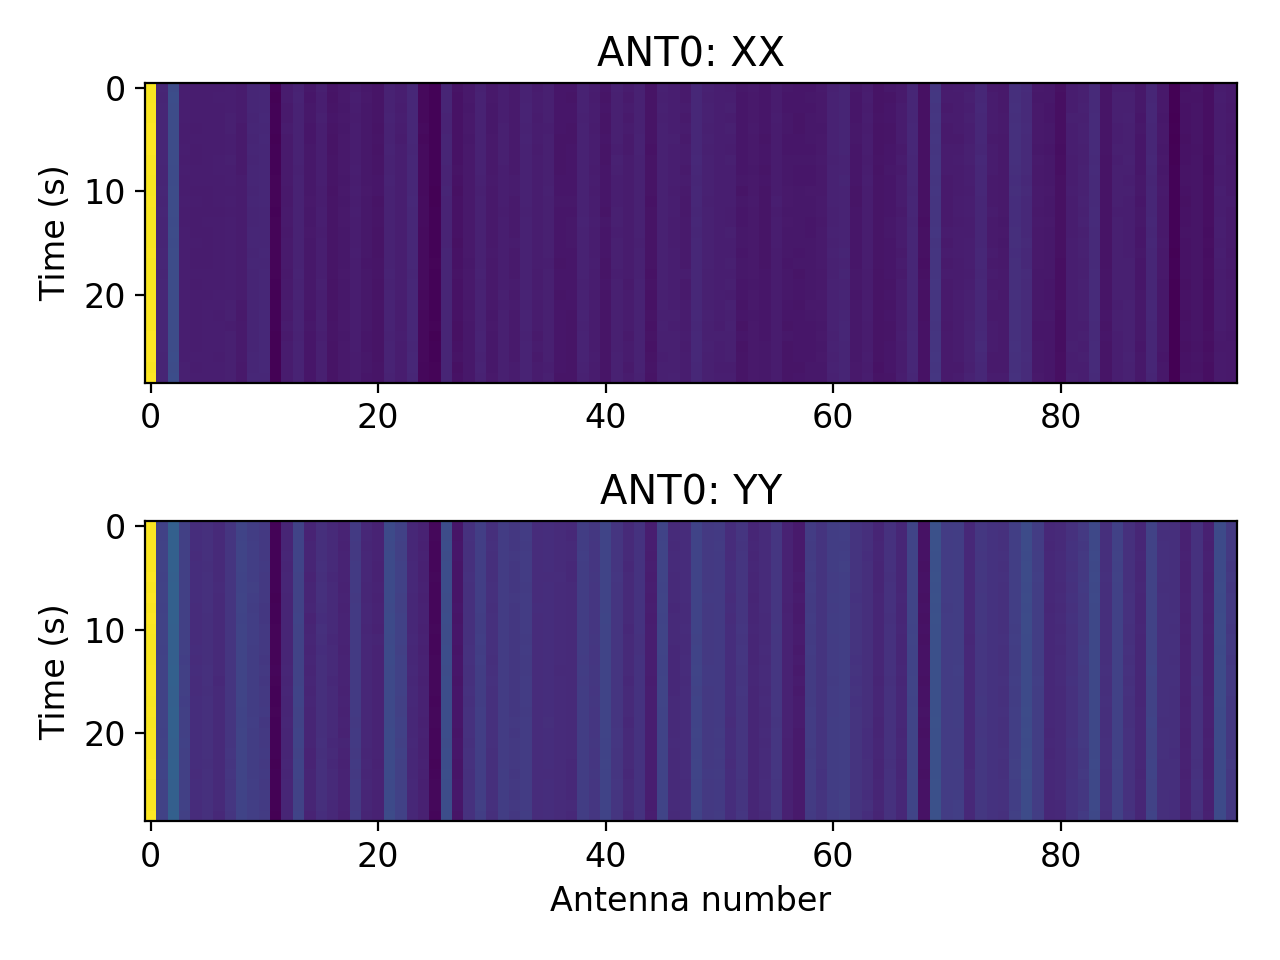

In [14]:
# Check how the various antennas/polarisation look with time
fig1, axes1 = subplots(nrows=2, ncols=1)
ax = axes1[0]
ax.imshow(cube_xx[:,0,:].real,aspect='auto')
ax.set_ylabel('Time (s)')
ax.set_title('ANT0: XX')
ax = axes1[1]
ax.imshow(cube_yy[:,0,:].real,aspect='auto')
ax.set_title('ANT0: YY')
ax.set_xlabel('Antenna number')
ax.set_ylabel('Time (s)')
tight_layout()

<IPython.core.display.Javascript object>


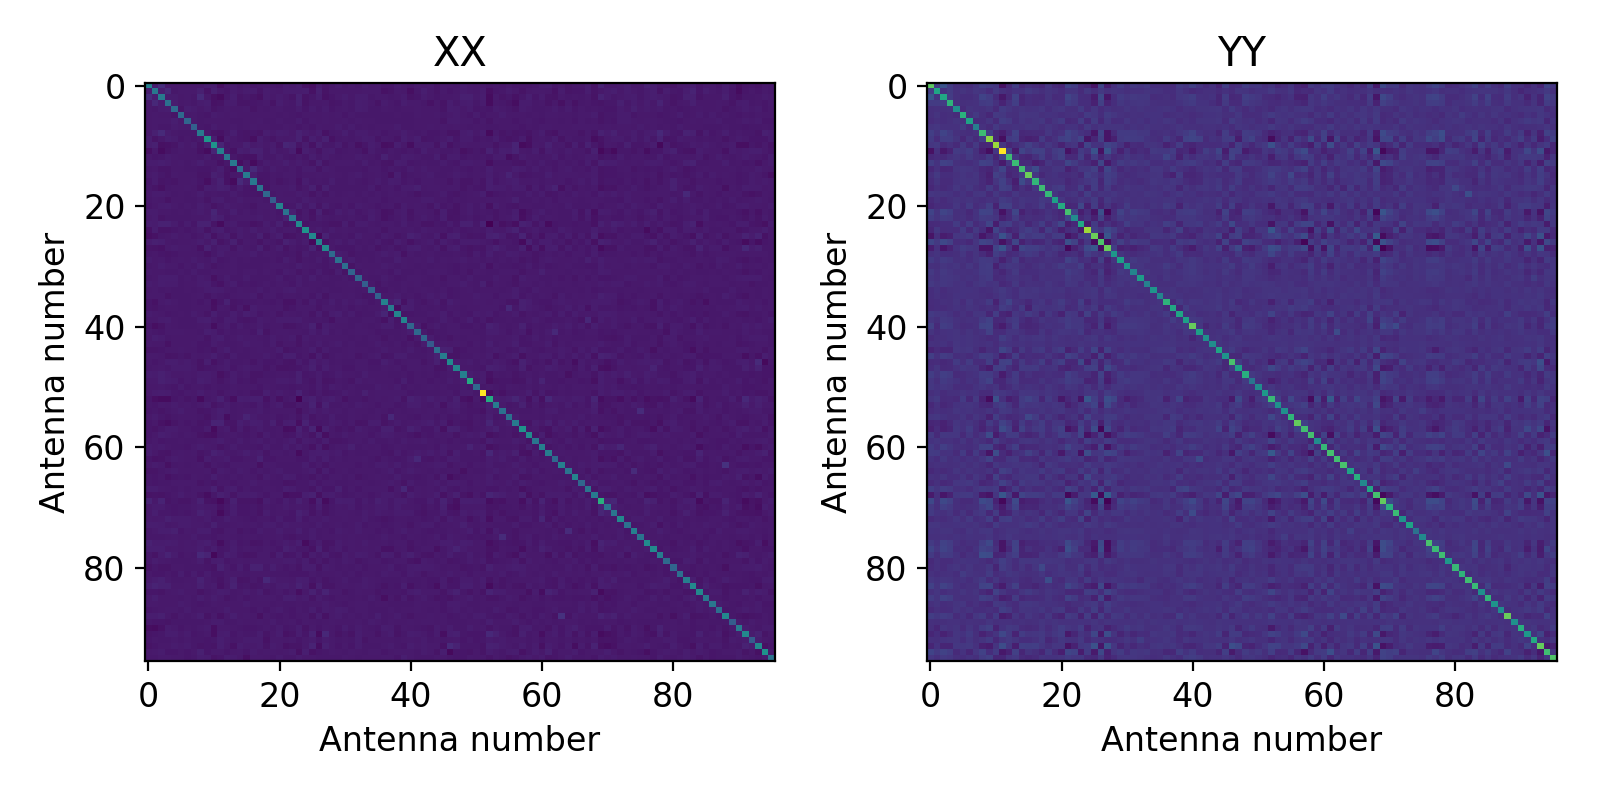

In [15]:
# Check how the correlations look with time
fig1, axes1 = subplots(nrows=1,ncols=2,figsize=(8,4))
ax = axes1[0]
ax.imshow(cube_xx[0,:,:].real,aspect='auto')
ax.set_xlabel('Antenna number')
ax.set_ylabel('Antenna number')
ax.set_title('XX')
ax = axes1[1]
ax.imshow(cube_yy[0,:,:].real,aspect='auto')
ax.set_title('YY')
ax.set_xlabel('Antenna number')
ax.set_ylabel('Antenna number')
tight_layout()

In [16]:
# Setup the database
db = LofarAntennaDatabase()

In [17]:
# Get the PQR positions for an individual station
station_pqr = db.antenna_pqr(station)

# Exception: for Dutch stations (sparse not yet accommodated)
if (stype == 'core' or stype == 'remote') and atype == 'inner':
    station_pqr = station_pqr[0:48,:]
elif (stype == 'core' or stype == 'remote') and atype == 'outer':
    station_pqr = station_pqr[48:,:]

<IPython.core.display.Javascript object>


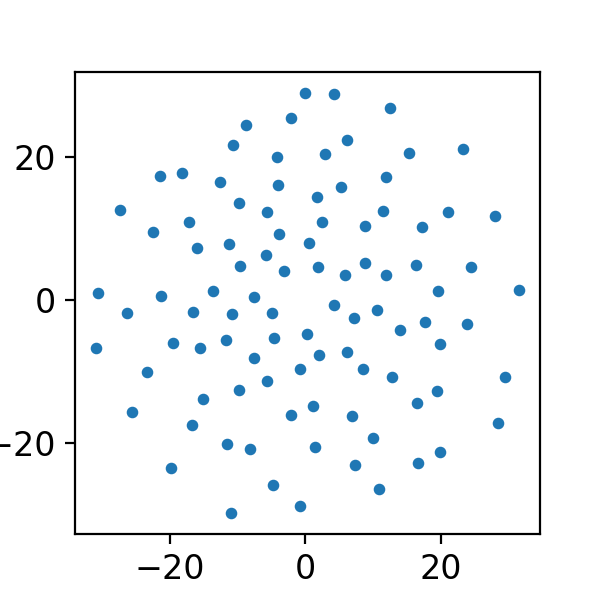

In [18]:
# Plot these positions (see layout of LBA)
figure(figsize=(3,3))
scatter(station_pqr[:,0],station_pqr[:,1],s=10)

In [19]:
# Check the shape of the PQR cube
station_pqr.shape

(96, 3)

In [20]:
# Establish an array to store the baseline offset positions
baselines = np.zeros([cube_xx.shape[1],cube_xx.shape[1],3])
baselines.shape

(96, 96, 3)

In [21]:
# For every antenna, calculate the "distance" between it and every other antenna
# THE SANDER METHOD!
start2 = time.time()
for i in range(0,cube_xx.shape[1]):
    baselines[i] = station_pqr[i]-station_pqr[:]
end2 = time.time()
print ('Time elapsed: %.3f ms' % ((end2-start2)*1000))

Time elapsed: 2.104 ms


In [22]:
# Check the shape of the baselines array
baselines.shape

(96, 96, 3)

<IPython.core.display.Javascript object>


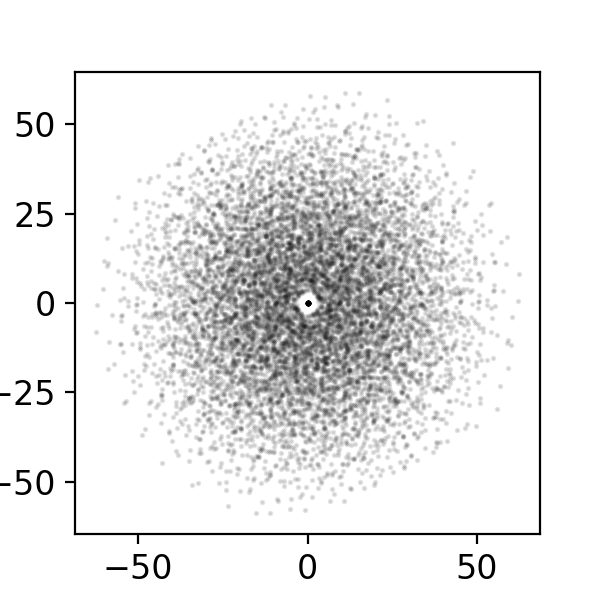

In [23]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
figure(figsize=(3,3))
scatter(baselines[:,:,0],baselines[:,:,1],facecolor='k',edgecolor='k',s=1,alpha=0.1)

In [24]:
# Account for the rotation
rotation = rotdict[station]
print ('Rotation for %s: %.2f deg' % (station,rotation))

Rotation for DE603LBA: -3.80 deg


/Users/moss/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/moss/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


<IPython.core.display.Javascript object>


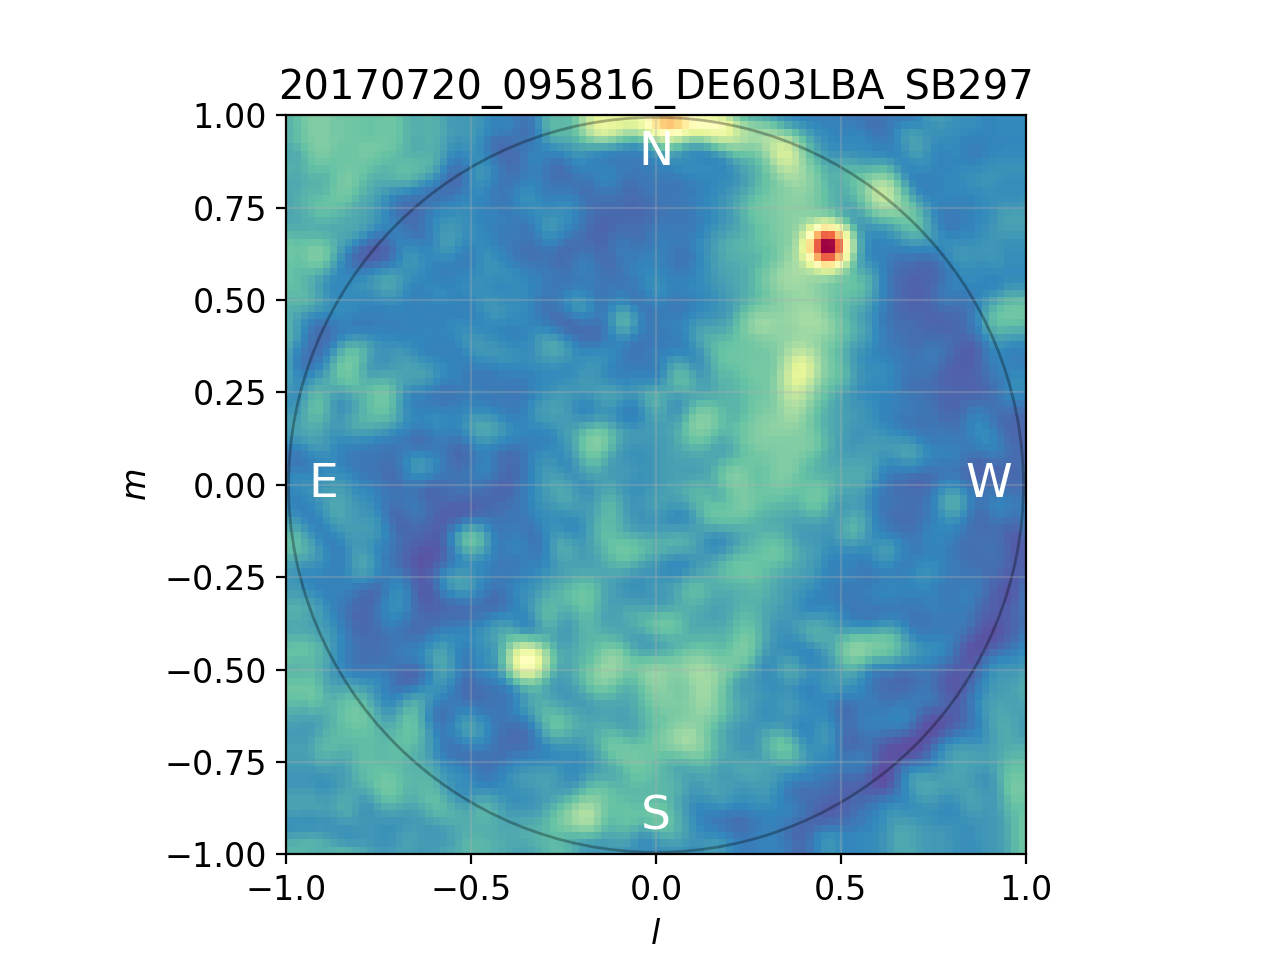

In [25]:
# Make a sky image, by numerically Fourier-transforming from visibilities to image plane

# Fourier transform, and account for the rotation (rotation is positive in this space)
#visibilities = cube_xx[2,:,:]
img = sky_imager(visibilities,baselines,freq,im_x,im_y)
img = ndimage.interpolation.rotate(img,rotation,reshape=False,mode='nearest')

# Plot the resulting image
figure()
imshow(img,origin='lower',cmap=cm.Spectral_r,extent=(-1,1,-1,1))
scatter(0,0,marker='o',facecolor='',edgecolor='k',s=7e4,linewidth=1,alpha=0.3)
xlabel('$l$')
ylabel('$m$')
#title('\_'.join(fname.split('_'))) # Only for fancy fonts
title(fname)

# Plot the compass directions
text(0.9,0,'W',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(-0.9,0,'E',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0,0.9,'N',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0,-0.9,'S',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)

grid(True,alpha=0.3)
savefig('%s_sky_calibrated.png' % fname,bbox_inches='tight',dpi=200)

/Users/moss/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


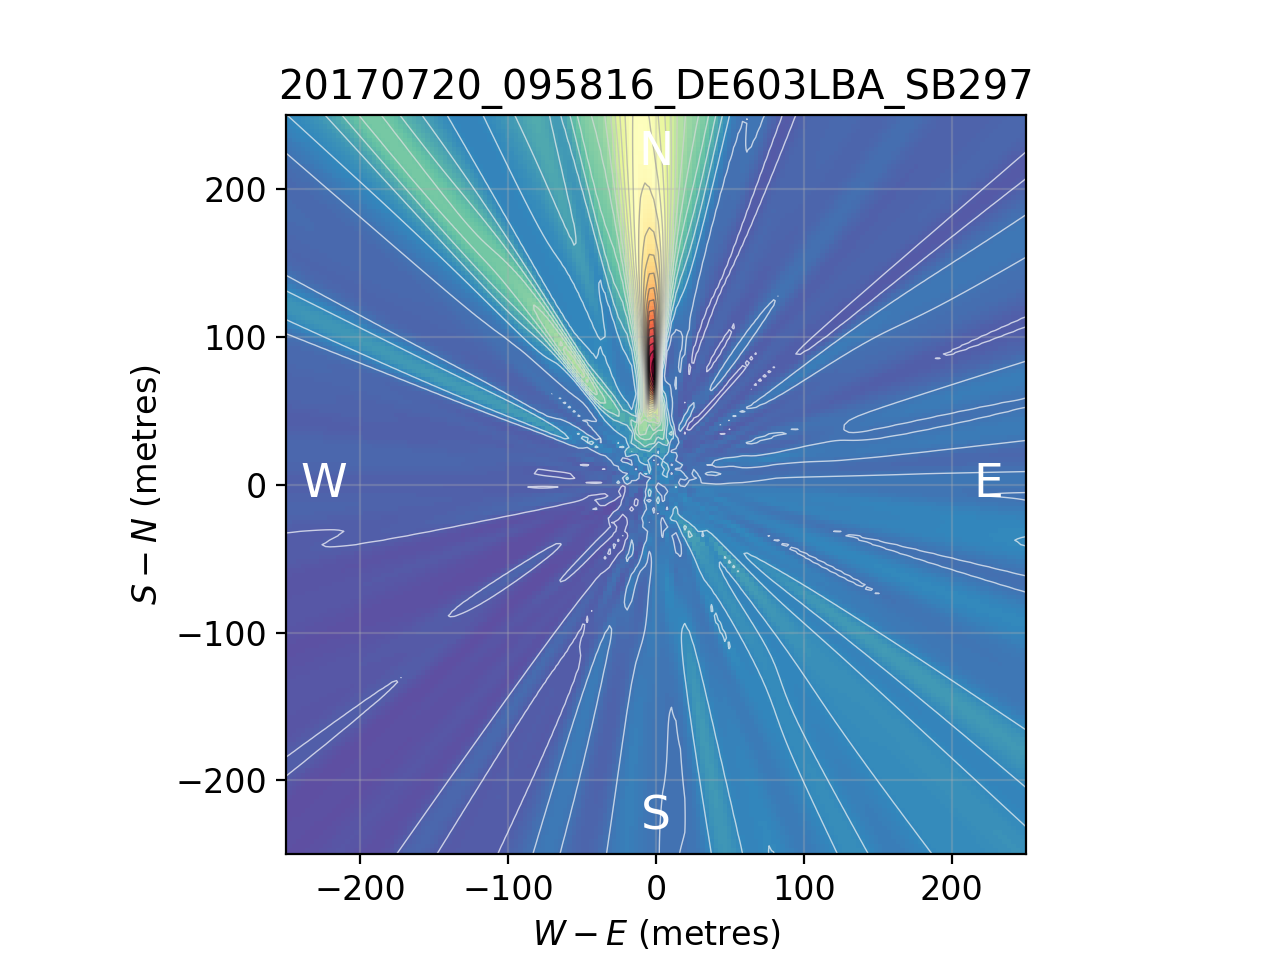

In [26]:
# Make a ground image, by numerically Fourier-transforming from visibilities to ground plane

# NOTE: dims currently must be centred on (0,0) for the rotation to work! 
#dims = np.array([-250,250,-250,250])
ratio = 0.5 # how many pixels per metre, default is 0.5 pixel/metre
im_x,im_y = int(ratio*(abs(dims[1]-dims[0]))),int(ratio*(abs(dims[3]-dims[2])))
dims2 = dims*1.5 # image further to account for rotation post-transform

# Fourier transform (rotation is negative in this space)
img = ground_imager(visibilities,baselines,freq,im_x,im_y,dims2,station_pqr,height=1.5)
img = ndimage.interpolation.rotate(img,-rotation,reshape=False,mode='nearest')

# Plot the resulting image
figure()
imshow(img,origin='lower',cmap=cm.Spectral_r,extent=dims2)
xlabel('$W-E$ (metres)')
ylabel('$S-N$ (metres)')
#title('\_'.join(fname.split('_'))) # Only for fancy fonts
title(fname)

# Custom range for dims (set to whatever is needed to zoom)
#dims = np.array([-150,0,-100,50]) # metres

# Change limits to match the original specified dimensions
xlim(dims[0],dims[1])
ylim(dims[2],dims[3])

# Place the NSEW coordinate directions
text(0.9*dims[1],(dims[2]+dims[3])/2.,'E',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text(0.9*dims[0],(dims[2]+dims[3])/2.,'W',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text((dims[0]+dims[1])/2.,0.9*dims[3],'N',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)
text((dims[0]+dims[1])/2.,0.9*dims[2],'S',horizontalalignment='center',verticalalignment='center',color='w',fontsize=17)

contour(img,30,origin='lower',cmap=cm.Greys,extent=dims2,color='w',linewidths=0.5,alpha=0.7)
grid(True,alpha=0.3)
savefig('%s_nearfield_calibrated.png' % fname,bbox_inches='tight',dpi=200)

In [27]:
# Check total time to run
end1 = time.time()
print ('Time elapsed: %.2f s' % (end1-start1))

Time elapsed: 48.16 s
